# Entraînement du modèle

Utilisation de the International Movie Database pour entrainer le modèle 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import plotly.express as px
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def cleaning_text(text):
    #Passage du texte en miniscules
    text=text.lower()
    #Suppression des chiffres
    text=re.sub(r'\d+', '', text)
    #Suppression de la ponctuation et des symboles spéciaux
    text=re.sub(r'[^\w\s]', '', text)
    return text


def count_common_words(text):
    words=text.split()
    dict={}
    for el in words :
        if el not in dict:
            dict[el]=1
        else:
            dict[el]+=1
    return dict

def most_common_words(dictionary):
    sorted_dict=dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict



def combine_dictionaries(df,df_column_name):
    combined_dict={}
    column_index=df.columns.get_loc(str(df_column_name))
    for i in range(len(df)):
        temp_dictionary=df.iloc[i,int(column_index)]

        for key, value in temp_dictionary.items():
            if key not in combined_dict:
                combined_dict[key]=value
            else:
                combined_dict[key]+=value
    return combined_dict

stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_stopwords(text):
    words = word_tokenize(text)
    cleaned_text=[word for word in words if word not in stops]
    return ' '.join(cleaned_text)

In [7]:
#Dans l'idéal, il aurait fallu utiliser un ensemble de reviews technologiques ou bien économiques mais n'ayant pas cela disposition, ni la possibilité de construire des ensembles d'entrainement de A à Z, nous allons utiliser l'IMDB qui devrait être suffisant pour retirer une compréhension générale des articles récupérés

df_imdb= pd.read_csv('/Users/dabadieraphael/Documents/GitHub/Python-pour-la-DS/IMDB Dataset.csv')
df_imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Analyse préliminaire du dataset

In [39]:
sentiment_counts = df_imdb['sentiment'].value_counts()
fig = px.pie(values=sentiment_counts.values, names=sentiment_counts.index, title='Répartition des sentiments dans la base')
fig.show()

In [44]:
print(f"Il y a {len(df_imdb)} critiques répertoriées dans cette base de données, également réparties entre les classes 'positive' et 'negative'")

Il y a 50000 critiques répertoriées dans cette base de données, également réparties entre les classes 'positive' et 'negative'


Exhibons le contenu de l'une d'entre elles

In [9]:
df_imdb.iloc[0,0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Intéressons-nous à la longueur de ces critiques

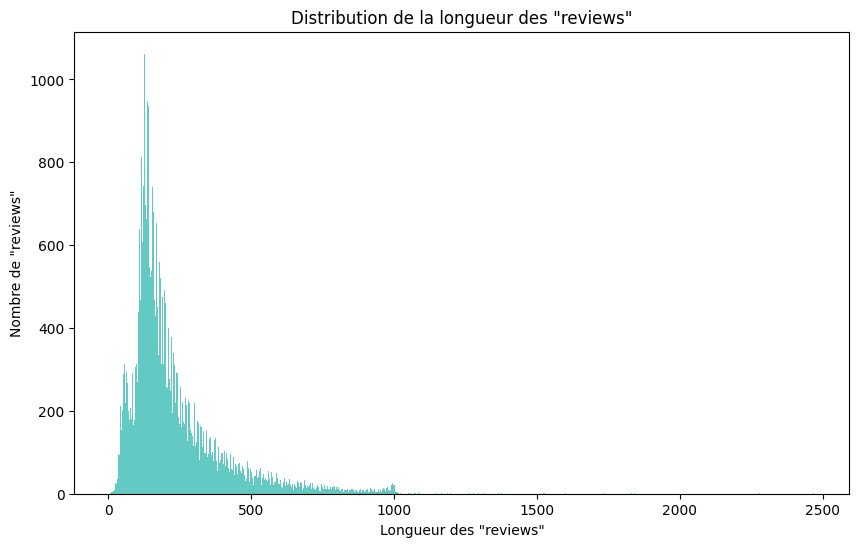

In [48]:
df_imdb['length']=df_imdb['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(df_imdb['length'], bins=1000, color='lightseagreen', alpha=0.7)
plt.title('Distribution de la longueur des "reviews"')
plt.xlabel('Longueur des "reviews"')
plt.ylabel('Nombre de "reviews"')
plt.show()

On remarque que la plupart des critiques ont une longueur comprise entre 100 et 500 mots. On constate également une "queue longue" qui indique que certaines critiques sont bien plus longues et peuvent atteindre jusqu'à 2500 mots.

In [50]:
df_imdb['length'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: length, dtype: float64

La méthode 'describe' permet de rentrer plus en détails :
- la longueur moyenne de ces critiques est de 231 mots
- L'écart type de 171 mots suggère une variation importante dans la longueur des critiques
- 75% des critiques ont une longueur de moins de 280 mots
- la critique la plus longue contient 2470 mots

Intéressons-nous aux **mots les plus fréquents** dans ces critiques

In [10]:
#On nettoie le texte en passant tout en minuscule et en supprimant les caractères inutiles

df_imdb['Content_cleaned']=df_imdb['review'].apply(cleaning_text)
df_imdb.head()

,review,sentiment,Content_cleaned
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


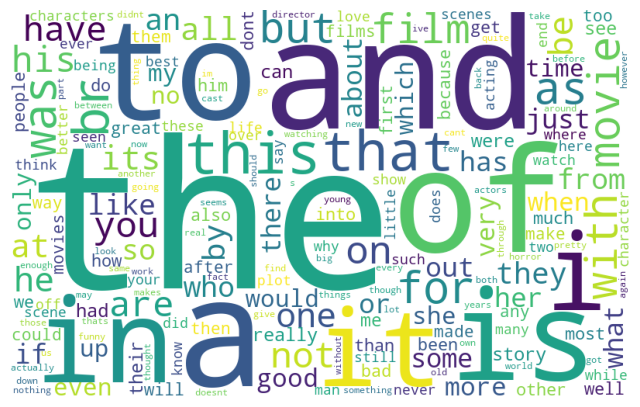

In [58]:
from wordcloud import WordCloud

#On réunit l'ensemble des critiques en un seul corpus.
text=' '.join(df_imdb['Content_cleaned'])
words=text.split()
word_counts=Counter(words)
wordcloud = WordCloud(width = 800, height = 500, background_color ='white').generate_from_frequencies(word_counts)


plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()


Les mots qui apparaissent le plus souvent sont sans surprise des stopwords. Nous les supprimons par la suite et affichons de nouveau un wordcloud sans eux.

In [11]:
df_imdb['Content_cleaned_from_stopwords']=df_imdb['Content_cleaned'].apply(clean_stopwords)
df_imdb.head()

,review,sentiment,Content_cleaned,Content_cleaned_from_stopwords
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the filmin...,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,petter matteis love time money visually stunni...


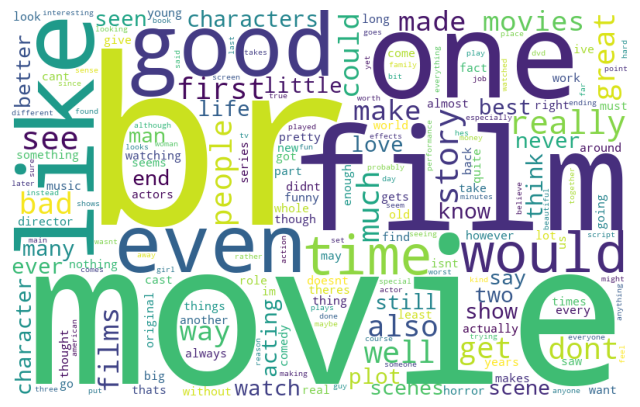

In [59]:
text=' '.join(df_imdb['Content_cleaned_from_stopwords'])
words=text.split()
word_counts=Counter(words)
wordcloud = WordCloud(width = 800, height = 500, background_color ='white').generate_from_frequencies(word_counts)


plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

Les mots les plus fréquents sont plus intéressants. On remarque toutefois que "br" revient souvent alors que ce mot n'a pas de sens.

In [61]:
df_imdb.iloc[0,0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

On remarque que <br /> apparaît au début des phrases. Supprimons ce caractère par défaut. 

In [64]:
df_imdb['Content_cleaned_from_stopwords'] = df_imdb['Content_cleaned_from_stopwords'].str.replace('br', '')
df_imdb['Content_cleaned_from_stopwords'].loc[0]

'one reviewers mentioned watching oz episode youll hooked right exactly happened me  first thing struck oz utality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word  called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away  would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class i

Rentrons dans une analyse descriptive plus poussée en **analysant les mots les plus fréquents** et en **explorant la corrélation entre longueur des critiques et sentiments exprimés**.

In [70]:
#Mots les plus fréquents

df_imdb['Counting_Words']=df_imdb['Content_cleaned_from_stopwords'].apply(count_common_words)
df_imdb['Most_common_words']=df_imdb['Counting_Words'].apply(most_common_words)
combined_dict=combine_dictionaries(df_imdb,'Most_common_words')

import plotly.express as px
from collections import Counter

sorted_text_dictionary=sorted(combined_dict.items(), key= lambda item:item[1], reverse=True)[:15]

keys=[key for key, value in sorted_text_dictionary]
values=[value for key, value in sorted_text_dictionary]


fig = px.bar(x=keys, y=values, title="Top 15 des mots les plus fréquents", labels={'x':'Mots', 'y':'Fréquences'}, color=values)
fig.show()

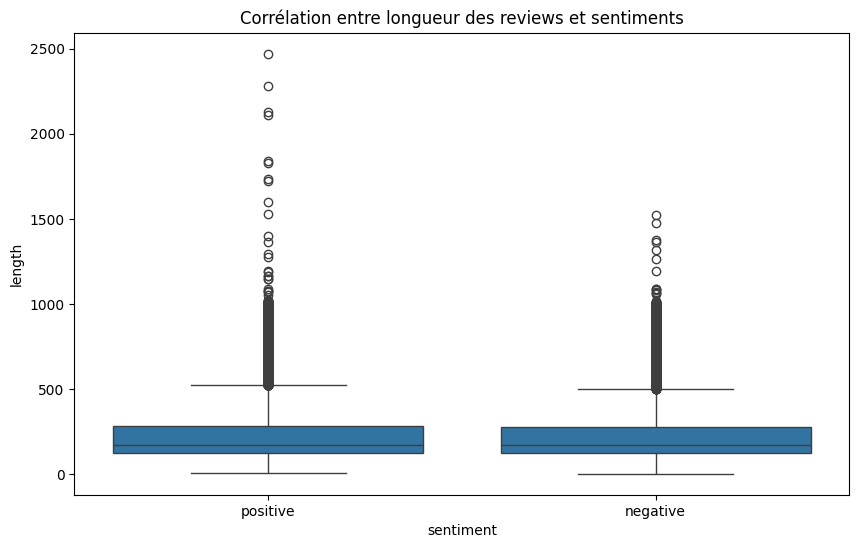

In [71]:
#Corrélation entre longueur et sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='length', data=df_imdb)
plt.title('Corrélation entre longueur des reviews et sentiments')
plt.show()

On remarque que :
- les médianes sont similaires entre les deux groupes comparés
- la dispersion des données représentée par la hauteur de chacune des boîtes est similaire
- il y a plus de valeurs aberrantes ou "outliers" dans la catégorie "positive" que "negative".

On en déduit qu'il n'y a pas de corrélation entre longueur de la critique et sentiment exprimé.

In [12]:
#Afin de rendre le texte utilisable pour l'entrainement de modèles de ML, nous vectorisons son contenu

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(max_features=2000)
X= vectorizer.fit_transform(df_imdb['Content_cleaned_from_stopwords'])
X

<50000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 3242663 stored elements in Compressed Sparse Row format>

In [13]:
# X est une matrice sparse (ou creuse) ie il a beaucoup de valeurs nulles. Nous cherchons à n'afficher que les valeurs non nulles de cette matrice afin de mieux comprendre ce qu'elle contient.
rows, columns = X.nonzero()
compteur=0
for row, column in zip(rows, columns):
    print(f"(Row, Col): ({row}, {column}), valeur: {X[row, column]}")
    compteur+=1
    if compteur==10:
        break

(Row, Col): (0, 1568), valeur: 0.0836816653194513
(Row, Col): (0, 1798), valeur: 0.10150607424144369
(Row, Col): (0, 155), valeur: 0.07901955788647734
(Row, Col): (0, 1096), valeur: 0.06483957191600687
(Row, Col): (0, 581), valeur: 0.08533340202807592
(Row, Col): (0, 1589), valeur: 0.11409542466225144
(Row, Col): (0, 1672), valeur: 0.09753383604607317
(Row, Col): (0, 971), valeur: 0.08538629467221116
(Row, Col): (0, 1825), valeur: 0.08770903191977768
(Row, Col): (0, 297), valeur: 0.09414022390525538


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(X,df_imdb['sentiment'],test_size=0.3)


Essayons de trouver le modèle qui convient le mieux entre une simple régression logisitique, random forest et des réseaux LSTM. On essaiera d'obtenir le maximum de chacun de ces 3 modèles et on retiendra le modèle entraîné le plus performant.

Commençons avec la régression logistique, le modèle le plus simple des trois. La régression logistique est normalement assez bien adaptée à des problèmes binaires. 

# Régression logistique

In [15]:
from sklearn.linear_model import LogisticRegression

logistic_regression=LogisticRegression()

#On entraîne le modèle sur l'ensemble d'entraînement extrait de l'IMDB Dataset.csv
logistic_regression.fit(X_train, Y_train)

LogisticRegression()

In [16]:
# Première évaluation de la performance du modèle

from sklearn.metrics import classification_report

Y_predicted= logistic_regression.predict(X_test)
print(classification_report(Y_test, Y_predicted ))

              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      7524
    positive       0.87      0.88      0.88      7476

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



Interprétation : 
- La précision (True positive / (True positive + False positive)) mesure l'exactitude du modèle. Ici elle est de 0,88 en moyenne. Dans le cas des reviews négatives, la précision est de 89%. Cela indique que parmi les reviews classées comme négatives par le modèle, 89% l'étaient vraiment.
- Le recall correspond au rapport True positive / (True positive + False negative). Par exemple si on prend le cas "negative", un recall de 87% indique que 87% des reviews correspondant à un sentiment négatif ont été détectées.
- Le F1 Score est la moyenne harmonique entre la précision et le recall. Il est de 88% ici.

Ces résultats sont d'ores et déjà assez satisfaisants. Par ailleurs on remarque que le modèle performe de manière similaire pour les deux classes. 

Dans le but de chercher à améliorer les performances du modèle, notamment en analysant plus en détails les valeurs de TP, TN, FN, FP. Pour cela on affiche la matrice de confusion. 

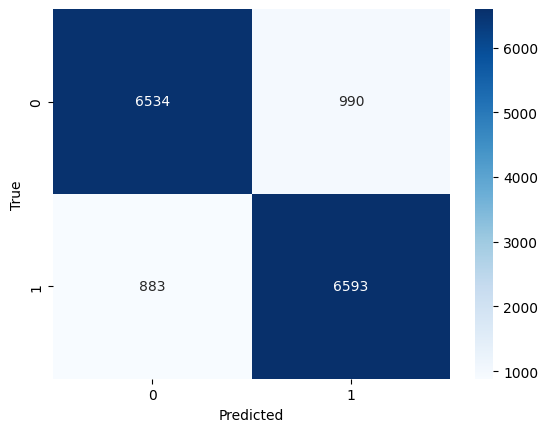

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test, Y_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Interprétation : 
- 6549 True negative
- 990 False positive 
- 883 False negative
- 6651 True positive

Pour améliorer un modèle de régression logistique, on peut notamment s'intéresser au seuil de probabilité utilisé pour décider de la classification. En ajustant ce seuil on peut notamment minimiser les faux positifs ou les faux négatifs. C'est notamment le cas lorsqu'on considère que se tromper dans un sens est plus coûteux que dans l'autre. Ici c'est le cas : nous voulons acheter que lorsque nous sommes sûrs que les articles récupérés sont positifs. Nous remarquons par ailleurs que le nombre de FP est supérieur au nombre de FN. Essayons de réduire les FP et voyons comment évolue la performance du modèle.

In [19]:
# On fixe par exemple le nouveau seuil à 0.6, ainsi pour que la prédiction soit considérée comme positive la probabilité devra être plus élevée qu'avant (0.6 > 0.5). 
# Il sera ainsi plus difficile d'être classé positif, ce qui devrait réduire la quantité de FP (le modèle doit être plus confiant qu'avant pour pouvoir annoncer qu'une review est positive)


from sklearn.metrics import precision_recall_curve
import numpy as np

Y_probas= logistic_regression.predict_proba(X_test)[:, 1] #probas estimées par le modèle que chaque prédiction appartiene à la classe (des reviews) positive(s)
#On modifie désormais les prédictions précédentes pour obtenir la nouvelle classification
threshold=0.6
Y_predicted_bis=np.where(Y_probas>=threshold,"positive", "negative")
Y_predicted_bis
print(classification_report(Y_test, Y_predicted_bis))

              precision    recall  f1-score   support

    negative       0.84      0.91      0.87      7524
    positive       0.90      0.82      0.86      7476

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



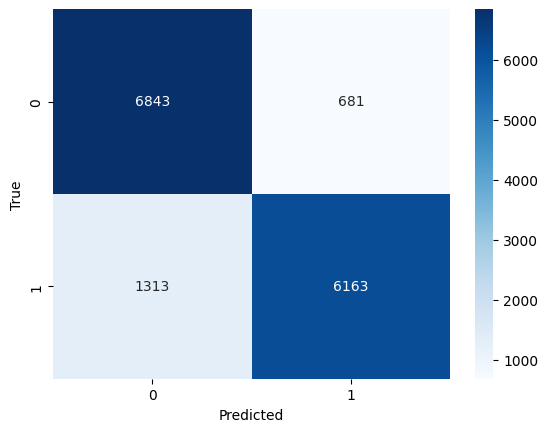

In [20]:
conf_mat = confusion_matrix(Y_test, Y_predicted_bis)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

On a bien fait diminuer le nombre de FP de 990 à 681. Le recall et le F1 score moyens ont très légerement diminué pour passer à 0.87 sur l'ensemble du dataset. À première vue, une telle évolution reste plutôt positive pour nous : nous prendrons moins de risque lorsque nous inciterons les utilisateurs à acheter.

On peut aussi s'intéresser à un autre paramètre pour améliorer la précision : le paramètre de régularisation. Ici, en particulier, on s'intéresse à l'inverse de ce paramètre. Il permet de pénaliser les poids du modèle afin de réduire les risques d'overfitting.

Afin de déterminer la valeur optimale de C, on peut utiliser la validation croisée. L'idée avec la validation croisée est de s'assurer que la valeur de C n'est pas optimal pour un unique sous-ensemble spécifique mais bien généralisable à de nouvelles instances. On considère les régressions Lasso (L1) et Ridge (L2)

In [21]:
from sklearn.model_selection import GridSearchCV

logistic_regression_2=LogisticRegression(max_iter=1000) #Si on ne spécifie pas un nombre maximal d'itération, on obtient "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."
grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
grid_search=GridSearchCV(logistic_regression_2, grid)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

{'C': 1}


In [22]:
#On a obtenu C=1, on peut essayer d'affiner la valeur de C en changeant la grille 


logistic_regression_2=LogisticRegression(max_iter=1000) #Si on ne spécifie pas un nombre maximal d'itération, on obtient "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."
grid={'C': [0.5, 0.75, 1, 1.25, 1.5, 2]} 
grid_search=GridSearchCV(logistic_regression_2, grid)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

{'C': 2}


In [23]:
#On continue à affiner 
logistic_regression_2=LogisticRegression(max_iter=1000) #Si on ne spécifie pas un nombre maximal d'itération, on obtient "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."
grid={'C': [2, 3, 4, 5, 6]} 
grid_search=GridSearchCV(logistic_regression_2, grid)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

{'C': 2}


On essaie d'affiner à nouveau la valeur de C.

In [40]:
logistic_regression_2=LogisticRegression(max_iter=1000) #Si on ne spécifie pas un nombre maximal d'itération, on obtient "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."
grid={'C': np.linspace(2, 3, num=20)} 
grid_search=GridSearchCV(logistic_regression_2, grid)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

{'C': 2.1052631578947367}


In [41]:
#On évalue désormais le modèle en prenant C=2.1 et le seuil de 0.6

logistic_regression_final=LogisticRegression(C=2.1) #On spécifie la valeur de C
logistic_regression_final.fit(X_train, Y_train)

Y_probas= logistic_regression_final.predict_proba(X_test)[:, 1] #probas estimées par le modèle que chaque prédiction appartiene à la classe (des reviews) positive(s)
threshold=0.6
Y_predicted_bis=np.where(Y_probas>=threshold,"positive", "negative")
Y_predicted_bis
print(classification_report(Y_test, Y_predicted_bis))

              precision    recall  f1-score   support

    negative       0.84      0.90      0.87      7524
    positive       0.90      0.83      0.86      7476

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



On a perdu 1 point de pourcentage de recall pour la classe négative et gagné 1 point de pourcentage de recall pour la classe positive. On détecte donc désormais 1% des reviews positives en plus et 1% des reviews négatives en moins.
Prendre C=2.1 permet donc ici de potentiellement considérer plus de moments opportuns d'achat ce qui peut s'avérer intéressant. Par ailleurs, la précision de 90% pour la classe positive contre 87% initiallement nous rassure : nous sommes sûrs à 90% qu'une prédiction de sentiment positif est correcte sur cet ensemble de données.

Les valeurs de recall, précision et F1 Score moyennes sont par ailleurs les mêmes à un point de pourcentage près.


# Random Forest

Les modèles de Random Forest sont plus robustes que les modèles de régression logistique. Ils permettent de capturer des relations non linéaires ce qui peut s'avérer fort utile pour de l'analyse de texte. Par ailleurs, ce sont des modèles qui nécessitent peu de fine tuning.

In [25]:
from sklearn.ensemble import RandomForestClassifier
random_forest= RandomForestClassifier(n_estimators=100) #On renseigne le nombre d'arbres. En ajoutant des arbres, on réduit le risque d'overfitting. On prend généralement entre 100 et 200 pour commencer.

random_forest.fit(X_train, Y_train)
Y_predicted_r_f=random_forest.predict(X_test)

print(classification_report(Y_test, Y_predicted_r_f))

              precision    recall  f1-score   support

    negative       0.84      0.85      0.84      7524
    positive       0.85      0.84      0.84      7476

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



On remarque des résultats à première vue moins satisfaisants que ceux obtenus avec la régression logistique avant fine-tuning.

In [26]:
print(confusion_matrix(Y_test, Y_predicted_r_f))

[[6396 1128]
 [1231 6245]]


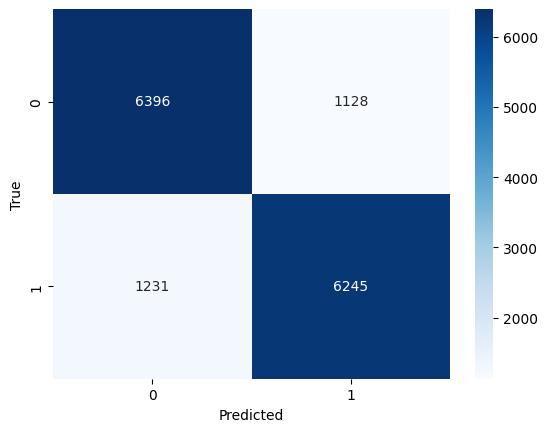

In [27]:
conf_mat = confusion_matrix(Y_test, Y_predicted_r_f)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
random_forest= RandomForestClassifier(n_estimators=50) #On renseigne le nombre d'arbres. En ajoutant des arbres, on réduit le risque d'overfitting. On prend généralement entre 100 et 200 pour commencer.

random_forest.fit(X_train, Y_train)
Y_predicted_r_f=random_forest.predict(X_test)

print(classification_report(Y_test, Y_predicted_r_f))

              precision    recall  f1-score   support

    negative       0.83      0.85      0.84      7524
    positive       0.84      0.82      0.83      7476

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



In [29]:
random_forest= RandomForestClassifier(n_estimators=200) 

random_forest.fit(X_train, Y_train)
Y_predicted_r_f=random_forest.predict(X_test)

print(classification_report(Y_test, Y_predicted_r_f))

              precision    recall  f1-score   support

    negative       0.84      0.85      0.85      7524
    positive       0.85      0.84      0.84      7476

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Les hyperparamètres les plus importants dans le fine tuning sont 
- "n_estimators" :le nombre d'arbres dans la forêt
- "max_features" : le nombre de features prises en compte à chaque scission
- "max_depth" : la profondeur maximale de l'arbre
- "min_samples_split" : nombre minimum d'échantillon pour scinder un noeud

Essayons donc de fine-tuner ces paramètres afin de gagner en précision. GridSearchCV peut prendre du temps à tourner. Essayons de visualiser l'évolution des performances du modèle lorsqu'un seul paramètre varie.

In [30]:
#Visualisons les performances du modèle lorsque nous faisons varier "n_estimators"

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

n_trees_grid=[10, 50, 100, 200, 400]

# On va récupérer les valeurs de précision du modèle ainsi que les temps d'exécution lorsque n_estimators prend les valeurs présentes dans cette grille

training_precisions = []
test_precisions = []
training_times = []

for n in n_trees_grid:
    rf=RandomForestClassifier(n_estimators=n)

    start_time=time.time()
    rf.fit(X_train, Y_train)
    end_time=time.time()

    duration = end_time-start_time

    training_predictions=rf.predict(X_train)
    test_predictions=rf.predict(X_test)

    #Comparaison des prédictions aux vraies valeurs
    training_precision=accuracy_score(Y_train, training_predictions)
    test_precision=accuracy_score(Y_test, test_predictions)

    #On ajoute ces résultats aux listes initiales
    training_precisions.append(training_precision)
    test_precisions.append(test_precision)
    training_times.append(duration)


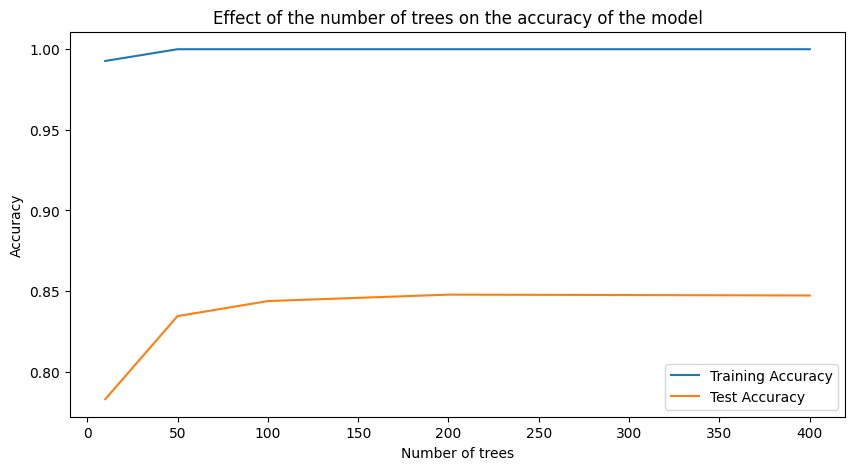

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(n_trees_grid, training_precisions, label='Training Accuracy')
plt.plot(n_trees_grid, test_precisions, label='Test Accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Effect of the number of trees on the accuracy of the model')
plt.legend()
plt.show()

In [32]:
training_precisions

[0.9927142857142857, 1.0, 1.0, 1.0, 1.0]

Text(0.5, 1.0, 'Training time VS number of trees')

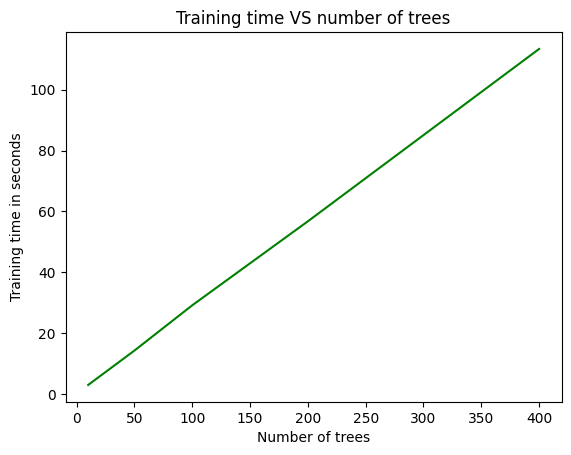

In [33]:
#On s'intéresse l'impact de l'augmentation du nombre d'arbres sur le temps d'entraînement du modèle

plt.plot(n_trees_grid, training_times, color='green')
plt.xlabel('Number of trees')
plt.ylabel('Training time in seconds')
plt.title('Training time VS number of trees')

Le premier graphique est une indication d'overfitting du modèle qui sur-performe sur l'ensemble d'entraînement atteignant une précision de 100%. Pour remédier à cela, on peut essayer de réduire la complexité du modèle.

Par défaut, 
- max_depth = None : les noeuds sont développés jusqu'à ce que toutes les feuilles soient pures ou contiennent moins que min_samples_split échantillons. On peut le fixer à des valeurs comme 10 ou 20
- min_samples_split = 2 : on peut passer cette valeur à 5 ou 1O.

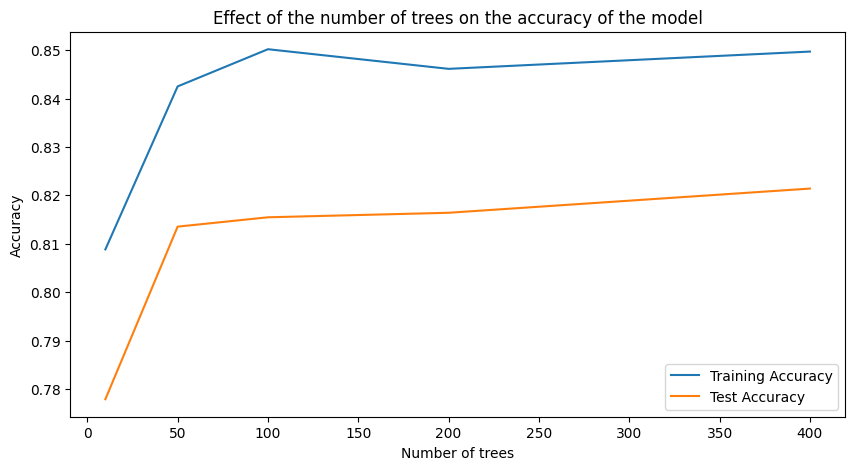

In [34]:
training_precisions_bis = []
test_precisions_bis = []
training_times_bis = []

for n in n_trees_grid:
    rf=RandomForestClassifier(n_estimators=n, max_depth=10, min_samples_split=5 )

    start_time=time.time()
    rf.fit(X_train, Y_train)
    end_time=time.time()

    duration = end_time-start_time

    training_predictions=rf.predict(X_train)
    test_predictions=rf.predict(X_test)

    #Comparaison des prédictions aux vraies valeurs
    training_precision=accuracy_score(Y_train, training_predictions)
    test_precision=accuracy_score(Y_test, test_predictions)

    #On ajoute ces résultats aux listes initiales
    training_precisions_bis.append(training_precision)
    test_precisions_bis.append(test_precision)
    training_times_bis.append(duration)

plt.figure(figsize=(10, 5))

plt.plot(n_trees_grid, training_precisions_bis, label='Training Accuracy')
plt.plot(n_trees_grid, test_precisions_bis, label='Test Accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Effect of the number of trees on the accuracy of the model')
plt.legend()
plt.show()

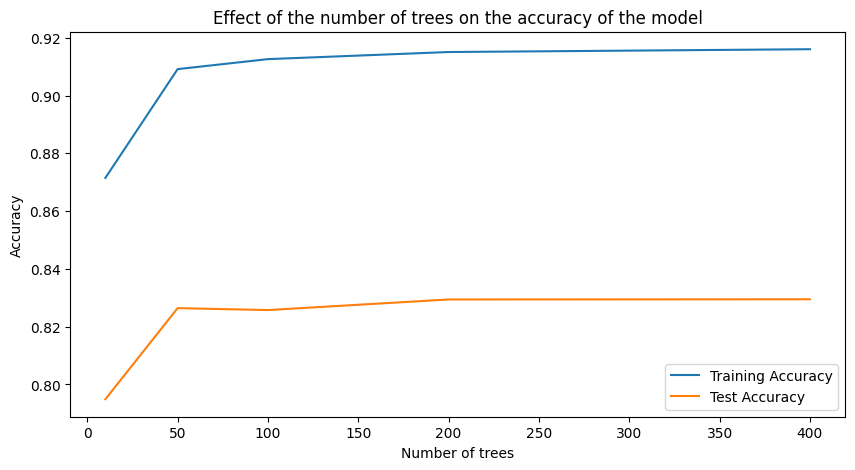

In [35]:
training_precisions_bis = []
test_precisions_bis = []
training_times_bis = []

for n in n_trees_grid:
    rf=RandomForestClassifier(n_estimators=n, max_depth=20, min_samples_split=5 )

    start_time=time.time()
    rf.fit(X_train, Y_train)
    end_time=time.time()

    duration = end_time-start_time

    training_predictions=rf.predict(X_train)
    test_predictions=rf.predict(X_test)

    #Comparaison des prédictions aux vraies valeurs
    training_precision=accuracy_score(Y_train, training_predictions)
    test_precision=accuracy_score(Y_test, test_predictions)

    #On ajoute ces résultats aux listes initiales
    training_precisions_bis.append(training_precision)
    test_precisions_bis.append(test_precision)
    training_times_bis.append(duration)

plt.figure(figsize=(10, 5))

plt.plot(n_trees_grid, training_precisions_bis, label='Training Accuracy')
plt.plot(n_trees_grid, test_precisions_bis, label='Test Accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Effect of the number of trees on the accuracy of the model')
plt.legend()
plt.show()

Ces résultats sont cohérents, nous avons rendu le modèle moins complexe donc il colle moins au données de l'ensemble d'entraînement. Par la même occasion, il perd légèrement en précision sur la base de test.

Afin d'améliorer la précision du modèle, on aurait pu augmenter la taille des données puisqu'un jeu de données plus grand bénéficie souvent à des modèles de Random Forest. Par choix, comme le modèle de régression logistique fournit des résultats plu satisfisants et que nous allons tester des réseaux de neurones complexes (LSTMs) dans la suite, nous en restons là pour le modèle de Random Forest.

# Long Short-Term Memory

Les LSTMs requièrent une phase de pré-traitement du texte bien plus importante. Conçus pour travailler avec des séquences de données, ils sont une évolution des Réseaux de Neurones Récurrents (RNN) et permettent notamment d'éviter les problèmes de vanishing gradient. Ils prennent en compte les dépendances séquentielles dans les données, ce qui les rend particulièrement performants pour prédire des séquences de mots ou assimiler des dépendances complexes dans les inputs comme nous pourrons l'exploiter aussi dans la partie de prévision du cours de l'action d'Apple. Ces caractéristiques nécessitent :

- la numérisation du texte (tokenisation)
- la normalisation des séquences de données de sorte à leur donner une longueur fixe (padding)
- l'odre séquentiel des features

## Tokenisation 

In [42]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#On définit le nombre maximal de mot pris en compte ci-dessous. De manière générale, 10000 mots est largement suffisant pour récupérer les mots les plus fréquents d'un langage.
#Les autres mots, moins importants (s'il y en a), ne seront pas pris en compte.

n_words=10000
tokenizer=Tokenizer(num_words=n_words)

#On construit désormais le dictionnaire interne à notre travail en se basant sur les 10000 mots considérés.
#La méthode fit_on_texts permet ici de donner un indice numérique unique à chacun d'entre eux

tokenizer.fit_on_texts(df_imdb['review'])

Pour plus de clarté, on peut visualiser le contenu de notre "dictionnaire"

In [ ]:
#Accédons à chaque mot unique 
word_index = tokenizer.word_index
df=pd.DataFrame({'Mot':word_index.keys()}, index=word_index.values())
df[:10]
    

À chaque token du texte est associé un indice. Affichons les 15 mots les plus fréquents de notre corpus.

In [ ]:
word_counts=tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

list_of_words=[]
list_of_frequences=[]
for word, frequence in sorted_word_counts:
    for i in range(10):
        list_of_words.append(word)
        list_of_frequences.append(frequence)

fig, ax = plt.subplots()
ax.bar(list_of_words, list_of_frequences)

ax.set_ylabel('Frequences')
ax.set_xlabel('Words')
ax.set_title('15 most frequent words')

    

Ce n'est pas une surprise, on retrouve des stopwords.

In [ ]:
print(f'Il y a {len(df)} tokens uniques dans notre vocabulaire.')

On remarque ici qu'il y a plus de tokens que la limite que nous avions spécifié pour n_words. À l'étape suivante, en appliquant la méthode texts_to_sequences, seuls les mots dont l'indice est inférieur à n_words seront gardés.

In [ ]:
sequences = tokenizer.texts_to_sequences(df_imdb['review'])
#sequences est une liste de liste : chaque review de IMDB est transformé en liste, à chaque mot on associe l'indice correspondant dans word_index
print(df_imdb.iloc[0,0])
print(sequences[0])

## Padding 

Comme expliqué précédemment, nous devons fixer une longueur type pour chaque séquence créée afin qu'elles soient toutes de même taille.

In [ ]:
#On prend par exemple la longueur de la séquence la plus longue dans la liste de listes "sequences"
max_len=max(len(sequence) for sequence in sequences)

sequence_lengths = [len(seq) for seq in sequences]
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(sequence_lengths)
plt.xlabel('Length of sequences')
plt.ylabel('Number of sequences')
plt.title("Distribution of the sequences' lenghts")
plt.show()

In [ ]:
#Les séquences de taille plus courte que max_len seront artificiellement rallongées en ajoutant des 0
padded_sequences = pad_sequences(sequences, maxlen=max_len)
print(padded_sequences[0])

## Construction du modèle LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

#On choisit des paramètres initiaux et assez courants. On pourra procéder à une phase de fine-tuning ensuite.

dim_embedding=128
lstm_units=50

#Création du modèle

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len)) #Transformation des indices en vecteurs
model.add(LSTM(lstm_units)) #Couche LSTM
model.add(Dense(1, activation='sigmoid')) #La fonction d'activation sigmoid est classique pour les problèmes de classification

#On compile le modèle 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Interprétation : 
- le modèle est assez grand puisqu'il possède 1,3 millions de paramètres.
- on a bien 50 unités de LSTMs, ce nombre peut-être amené à changer dans la phase de fine tuning.

## Entraînement du modèle 

In [ ]:
# On convertit la colonne "sentiment" de df_imdb en binaire

df_imdb['labels']=df_imdb['sentiment'].apply(lambda x : 1 if x=='positive' else 0)

In [ ]:
# On crée les ensembles d'entrainement, de validation et de test

from sklearn.model_selection import train_test_split
#Création des ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, df_imdb['labels'], test_size=0.2, random_state=42)

#Division de l'ensemble d'entraînement en ensembles de validation et d'entraînement
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) 
#0.25 x 0.8 = 0.2 (25% de l'ensemble d'entraînement, soit 20% du total, est alloué à la validation)

history = model.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc)

On distingue déjà des élements qui nous font penser à de l'overfitting. Traçons l'évolution des performances du modèle au cours de ces 10 epochs.

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

steps=[i for i in range(1,11)]

plt.plot(steps, accuracy, label="Précision sur l'ensemble d'entraînement")
plt.plot(steps, val_accuracy, label="Précision sur l'ensemble de validation")
plt.title("Précision sur les ensembles d'entraînement et de validation")
plt.legend()

plt.figure()

In [ ]:
plt.plot(steps, loss, label='Training loss')
plt.plot(steps, val_loss, label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

Avec quelques recherches, on apprend que les meilleures performances réalisées à ce jour sur l'ensemble IMDB est une accuracy de 96,2%. Par ailleurs, et plus simplement, on observe qu'au  bout de 2 epochs, les performances sur l'ensemble d'entraînement se stabilisent et n'augmentent plus. De même au bout de 2 epochs, on constate que les pertes réalisées sur l'ensemble de validation croissent alors que sur l'ensemble d'entraînement on arrive au bout de 10 epochs à une précision aberrante de 0.9876 et une perte de 0.0402 ce qui est bien trop optimiste pour notre modèle.

On est donc ici face à un cas d'**overfitting**.

Au bout de 2 epochs cependant, on obtient une validation accuracy de presque 90%, ce qui est mieux qu'avec notre régression logistique initiale. Cela est rassurant et nous laisse penser qu'en fine tunant un peu le modèle et en limitant l'overfitting, on pourra obtenir des résultats encore plus satisfaisants.

## Lutter contre l'overfitting
### Technique de dropout 

**Modèle v2**

In [ ]:
from tensorflow.keras.layers import Dropout, SpatialDropout1D

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len)) #Transformation des indices en vecteurs
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_units)) #Couche LSTM
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) #La fonction d'activation sigmoid est classique pour les problèmes de classification

#On compile le modèle 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_V2 = model.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))
test_loss_V2, test_acc_V2 = model.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc)

Il ne semble pas y avoir de différence significative

### Early stopping

Le "early stopping" est une technique utilisée pour prévenir l'overfitting durant l'entraînement. Dès lors que les performances réalisées sur l'ensemble de validation ne s'améliore plus pendant un certain temps, l'entraînement est arrêté. Cela évite de continuer l'entraînement dans le vide.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping=EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2, verbose=1)
history_V2 = model.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping])
test_loss_V2, test_acc_V2 = model.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc)

In [ ]:
accuracy = history_V2.history['accuracy']
val_accuracy = history_V2.history['val_accuracy']
loss = history_V2.history['loss']
val_loss = history_V2.history['val_loss']

steps=[i for i in range(1,4)]

plt.plot(steps, accuracy, label="Précision sur l'ensemble d'entraînement")
plt.plot(steps, val_accuracy, label="Précision sur l'ensemble de validation")
plt.title("Précision sur les ensembles d'entraînement et de validation")
plt.legend()

plt.figure()

In [ ]:
plt.plot(steps, loss, label='Training loss')
plt.plot(steps, val_loss, label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

### Fine tuning des paramètres

Ayant observé de l'overfitting, on va réduire le nombre de couches de LSTM afin d'éviter ce phénomène de surajustement.

In [ ]:
dim_embedding=128
lstm_units=25

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len)) #Transformation des indices en vecteurs
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_units)) #Couche LSTM
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stopping=EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2, verbose=1)
history_V4 = model.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))
test_loss_V4, test_acc_V4 = model.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc)

In [ ]:
accuracy = history_V4.history['accuracy']
val_accuracy = history_V4.history['val_accuracy']
loss = history_V4.history['loss']
val_loss = history_V4.history['val_loss']

steps=[i for i in range(1,5)]

plt.plot(steps, accuracy, label="Précision sur l'ensemble d'entraînement")
plt.plot(steps, val_accuracy, label="Précision sur l'ensemble de validation")
plt.title("Précision sur les ensembles d'entraînement et de validation")
plt.legend()

plt.figure()

In [ ]:
dim_embedding=128
lstm_units=100

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len)) #Transformation des indices en vecteurs
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_units)) #Couche LSTM
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping=EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2, verbose=1)
history_V3 = model.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping])
test_loss_V3, test_acc_V3 = model.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc)

### Changement du taux de dropout